In [1]:
from gurobipy import *
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import pandas as pd
import numpy as np
from IPython.display import clear_output

Limpeza

In [2]:
def geojson_builder(down_left,up_right,travels=0):
    """
    Build a rectangle geojson from two points.
    """
    p1 = [str(down_left[0]),str(down_left[1])]
    p2 = [str(up_right[0]),str(down_left[1])]
    p3 = [str(up_right[0]),str(up_right[1])]
    p4 = [str(down_left[0]),str(up_right[1])]
    
    geojson = {"type": "FeatureCollection",
              "features": [
                {"type": "Feature",
                    "properties":{
                        "arrivals_outs": travels
                    },
                    "geometry": {
                        "type": "Polygon",
                        "coordinates": [[p1,p2,p3,p4,p1]] }}]}

    return geojson

In [3]:
def build_regions(data, points):
    """
    Create a list of geojsons that represent the group more 
    significant in the region.
    """
  
    # Creating matrix of the region coordinates
    # matrix dimensions based in points
    lat = points['lat'].unique()
    step = round(abs(lat[0]-lat[1]),5)
    diff = abs(lat.max() - lat.min())

    len_y = int(diff/step)+1

    lon = points['lon'].unique()
    step = round(abs(lon[0]-lon[1]),5)
    diff = abs(lon.max() - lon.min())

    len_x = int(diff/step)+1
    
    
    matrix = []

    # filling the matrix with the points coordinates
    c = 0
    for y in range(len_y):
        line = []
        for x in range(len_x):
            line.append((points['lon'].iloc[c], points['lat'].iloc[c]))
            c+=1
        matrix.append(line)

    geojsons = []
    
    # Column options for travels and idle datasets
    start_lat = 'Start_lat'
    start_lon = 'Start_lon'
    end_lat = 'End_lat'
    end_lon = 'End_lon'
    
    for lin in range(len(matrix)-1):
        for col in range(len(matrix[0])-1):

            # Selecting all points inside a square of matrix coordinates
            down_left = matrix[lin][col]
            up_right = matrix[lin+1][col+1]
            
            start_lon_condition = (data[start_lon] >= down_left[0]) & (data[start_lon] <= up_right[0])
            start_lat_condition = (data[start_lat] >= down_left[1]) & (data[start_lat] <= up_right[1])
            
            end_lon_condition = (data[end_lon] >= down_left[0]) & (data[end_lon] <= up_right[0])
            end_lat_condition = (data[end_lat] >= down_left[1]) & (data[end_lat] <= up_right[1])

            start_travels = data.loc[start_lon_condition & start_lat_condition]
            end_travels = data.loc[end_lon_condition & end_lat_condition]

#             if len(start_travels) != 0:
            # Build a geojson
            geojsons.append(geojson_builder(down_left,up_right, len(start_travels)+len(end_travels)))

            # Changing start region of the travels
            data.loc[start_lon_condition & start_lat_condition, 'start_region'] = len(geojsons)-1
            data.loc[end_lon_condition & end_lat_condition, 'end_region'] = len(geojsons)-1
            
    data.dropna(axis=0, inplace=True)

            
    return geojsons

In [4]:
def limpeza(data):
    # only travels with more than 30 minutes of duration, that is the limit of cancellation of a reserve
    data = data[(data['duration'] > 30) | (data['distance'] > 3)]

    data.Start_time = pd.to_datetime(data.Start_time)
    data.End_time = pd.to_datetime(data.End_time)

    # Colleting vehicle ids
    car_ids = list(data.Id.unique())

    # Removing uncommon ids
    # Ex: 4c5865a3-4b03-40f6-a3a8-d4e94aae3b17
    ids_uncommon = [id for id in car_ids if id.find('-') != -1]
    car_ids = [id for id in car_ids if id.find('-') == -1]

    data = data[~data.Id.isin(ids_uncommon)]
    
    data.reset_index(inplace=True, drop=True)
    
    return data

In [5]:
def get_data(path, time_space='m', time_interval='1-w'):
    """
        Retorna dados por meio de um dataframe e sua lista de regiões.
    """
    data = pd.read_csv(path)
    print('Limpando dados...')
    data = limpeza(data) # limpando dados
    
    assert time_space == 'h' or time_space == 'm'
    print('Selecionando espaço de tempo...')
    # selecionando se o espaço de tempo será em horas ou minutos
    if time_space == 'h':
        data.Start_time = data.Start_time.apply(lambda x: x.replace(minute=0,second=0, microsecond=0))
        data.End_time = data.End_time.apply(lambda x: x.replace(minute=0,second=0, microsecond=0))
    elif time_space == 'm':
        data.Start_time = data.Start_time.apply(lambda x: x.replace(second=0, microsecond=0))
        data.End_time = data.End_time.apply(lambda x: x.replace(second=0, microsecond=0))
    
    print('Selecionando periodo de coleta...')
    # selecionando periodo a ser analisado
    value, period = time_interval.split('-')
    
    assert period in ['d','w','m']
    
    if period == 'd': mult = 1
    elif period == 'w': mult = 7
    elif period == 'm': mult = 30
        
    inicio = data.Start_time[0]
    fim = inicio + timedelta(days=int(value) * mult)
    
    data = data[data.End_time <= fim]
    
    print('Criando regiões...')
    # Creating points of Vancouver region
    latitudes = []
    longitudes = []
    step =0.004
    for lat in np.arange(data['Start_lat'].min(),data['Start_lat'].max()+step,step):
        for lon in np.arange(data['Start_lon'].min(),data['Start_lon'].max()+step,step):
            latitudes.append(lat)
            longitudes.append(lon)

    points = pd.DataFrame({'lon':longitudes, 'lat':latitudes})
    
    # estabelecendo e adicionando coluna de regioes
    regions = build_regions(data, points)
    
    # removendo regioes sem viagens
    regions = [r for r in regions if r['features'][0]['properties']['arrivals_outs'] != 0]
    regions.insert(0,None)
        
    return data, regions

In [6]:
data, regions = get_data('../data/evo_travels.csv', 'h', '1-d')

Limpando dados...


/home/victor/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Selecionando espaço de tempo...
Selecionando periodo de coleta...
Criando regiões...


### Localizando viagens por regiões em vez de coordenadas

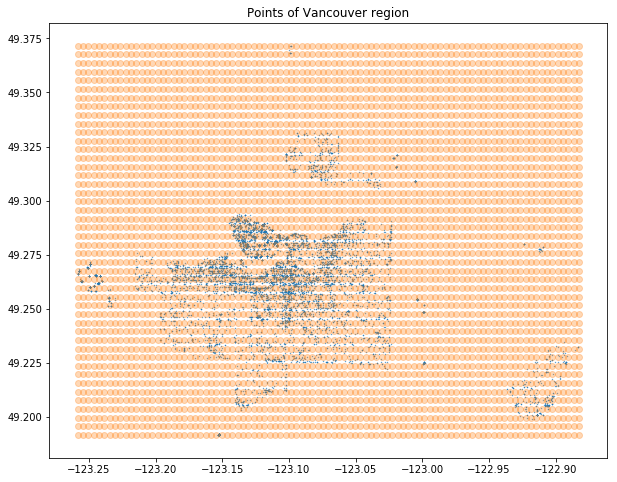

In [7]:
# Creating points of Vancouver region
latitudes = []
longitudes = []
step =0.004
for lat in np.arange(data['Start_lat'].min(),data['Start_lat'].max()+step,step):
    for lon in np.arange(data['Start_lon'].min(),data['Start_lon'].max()+step,step):
        latitudes.append(lat)
        longitudes.append(lon)

points = pd.DataFrame({'lon':longitudes, 'lat':latitudes})

plt.figure(figsize=(10,8))
plt.scatter(data['Start_lon'], data['Start_lat'], s=0.1)
plt.scatter(points['lon'], points['lat'], alpha=0.3)
plt.title('Points of Vancouver region')

plt.show()

In [8]:
data.head()

,Id,Start_time,Start_lat,Start_lon,Fuel_start,End_time,End_lat,End_lon,Fuel_end,duration,distance,start_region,end_region
0,JTDKDTB32G1589000,2018-03-01 12:00:00,49.225563,-122.894234,84,2018-03-01 13:00:00,49.314045,-123.083481,84,38.657753,1.688120e+04,843.0,2863.0
1,JTDKDTB32G1589000,2018-03-01 18:00:00,49.314045,-123.083481,84,2018-03-01 20:00:00,49.315067,-123.083481,83,108.456289,1.136032e+02,2863.0,2863.0
2,JTDKDTB32G1589000,2018-03-01 20:00:00,49.315067,-123.083481,83,2018-03-01 21:00:00,49.315067,-123.083481,83,30.452687,7.068790e-10,2863.0,2863.0
3,JTDKDTB32G1589000,2018-03-01 21:00:00,49.315067,-123.083481,83,2018-03-01 21:00:00,49.327805,-123.081482,83,14.545000,1.422821e+03,2863.0,3240.0
4,JTDKDTB32G1589000,2018-03-02 04:00:00,49.327805,-123.081482,83,2018-03-02 05:00:00,49.288547,-123.119751,80,26.307881,5.169018e+03,3240.0,2290.0


In [9]:
len(regions)

859

In [10]:
len(data)

9570

In [11]:
# Dados que serão utilizados no modelo

# Todos os instantes de tempo em timestamp
time_instants = pd.date_range(start=data.Start_time.min(), end=data.End_time.max(), freq='h') 
viagem_id = data.index.values                   # id de todas as viagens
n_vehicles = len(data.Id.unique())              # numero total de veículos
custo_h = 15.0                                  # custo por hora

In [21]:
m = Model("realocacao")

In [22]:
# Variável que indica se ocorreu a viagem com realocação para p
locais = [None] + list(data.start_region.unique())
viagens_realizadas = {}
c = 0
for v in viagem_id:
    c+=1
    print('Quantas viagens faltam:',len(viagem_id) - c)
    print('Tamanho do vetor de x:', len(viagens_realizadas))
    start_region = data.start_region.loc[v]
    for p in locais:
        # Só é possível a realocação se em algum momento ocorreu uma viagem com mesma origem e destino
        end_in_p = data[(data.start_region == start_region) & (data.end_region == p)]
        if len(end_in_p) > 0 or p is None:
            viagens_realizadas[(v,p)] = m.addVar(vtype=GRB.BINARY, name='x_'+str(v)+'_'+str(p))
    clear_output()

Quantas viagens faltam: 9507
Tamanho do vetor de x: 1066


KeyboardInterrupt: 

In [23]:
# Variável que indica quantos veículos estão em cada estação em dado momento
veiculos_ociosos = {}
for l in locais:
    for t in time_instants:
        veiculos_ociosos[(l,t)] = m.addVar(vtype=GRB.INTEGER, name='e_'+str(l)+'_'+str(t.value))

In [24]:
# restrição de fluxo
viagens_r = viagens_realizadas.keys()

for t in range(1,len(time_instants)): #para todo instante t
    viagens_t = data[data.Start_time == time_instants[t-1]].index.values #tempo anterior
    viagens_t2 = data[data.Start_time == time_instants[t]].index.values #atual
    for p in locais: #ponto de parada
        viagens_p = data[data['end_region'] == p].index.values #viagens de outros lugares para p
        viagens_p2 = data[data['start_region'] == p].index.values # viagens de um ponto específico para outros lugares
        m.addConstr(
            veiculos_ociosos[p,time_instants[t-1]] + quicksum(viagens_realizadas[v,p] for v in viagens_p if (v,p) in viagens_r) == quicksum(viagens_realizadas[v,p]for v in viagens_p2 if (v,p) in viagens_r) + veiculos_ociosos[p,time_instants[t]],"fluxo_"+str(p)+"_"+str(time_instants[t].value)
        )

In [25]:
# restrição para indicar o número de veículos em cada estação
m.addConstr(quicksum(veiculos_ociosos[p,time_instants[0]] for p in locais) == n_vehicles, name='n_veiculos')

<gurobi.Constr *Awaiting Model Update*>

In [26]:
# restrição para evitar veículos realizarem mais de uma viagem ao mesmo tempo
for v in viagem_id:
    m.addConstr(
        quicksum(viagens_realizadas[v,p] for p in locais if (v,p) in viagens_realizadas.keys())==1
    , name='quant_viagem_'+str(v))

In [27]:
#função objetivo
m.setObjective(quicksum(
    quicksum(
        custo_h*viagens_realizadas[i,p]
        for p in locais if (i,p) in viagens_r)
    for i in viagem_id)
    - quicksum(
        quicksum(
            custo_h*veiculos_ociosos[p,t]
            for t in time_instants)
    for p in locais), GRB.MAXIMIZE)

In [28]:
m.write("model.lp")

In [29]:
m.optimize()

Optimize a model with 33175 rows, 25529 columns and 51597 nonzeros
Variable types: 0 continuous, 25529 integer (1082 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+03]
Presolve time: 0.01s

Explored 0 nodes (0 simplex iterations) in 0.04 seconds
Thread count was 1 (of 4 available processors)

Solution count 0

Model is infeasible
Best objective -, best bound -, gap -
